# Sales & Trading Excercise: 

### Bryan Marty, CFA

### Corporate Bonds

This exercise is about fixed income markets. Corporate bonds are largely traded in OTC markets. Academic
Corporate Bond TRACE Dataset contains historic transaction-level data on all eligible corporate bonds—
investment grade, high yield and convertible debt. We use this dataset to understand the bond market during
the COVID-19 Crisis.
• bond.csv.zip is the dataset containing TRACE data downloaded from WRDS
• VariableList.csv contains the variable description, and more detailed description is in TRACE Variable.pdf

### Questions:

1) Variable “ascii rptd vol tx” records each trade’s quantity. However, trades more than 1 million and 5
millions are not recorded in the numerical format. Please replace “1MM+” to 1,000,000 and “5MM+” to
5,000,000

In [80]:



# Importing libraries
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, linalg
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from time import time
from datetime import timedelta
from ta.volume import VolumeWeightedAveragePrice





bond_trading_assignment = r"C:\Users\user\Documents\bond_trading_assignment.csv"

# Move all Variables to datetime
df = pd.read_csv(bond_trading_assignment, parse_dates= ['trans_dt'])
# df = df.set_index(df['trans_dt'])

df.columns 
# GAH! this is a UTC timestamp, not integer.  Convert to string then datetime
df['trd_exctn_dt'] = df['trd_exctn_dt'].apply(str)
df['trd_exctn_dt'].apply(type)
df['trd_exctn_dt'] = pd.to_datetime(df['trd_exctn_dt'], errors='coerce', format = '%Y-%m-%d')

df['sttl_dt'] = df['sttl_dt'].apply(str)
df['sttl_dt'] = pd.to_datetime(df['sttl_dt'], errors = 'coerce', format = '%Y-%m-%d')



C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16,22,27,30,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [81]:

#question 1
df['ascii_rptd_vol_tx'] = df.apply(lambda x: 1000000 if (x['ascii_rptd_vol_tx'] == '1MM+') else x['ascii_rptd_vol_tx'], axis = 1)
df['ascii_rptd_vol_tx'] = df.apply(lambda x: 5000000 if (x['ascii_rptd_vol_tx'] == '5MM+') else x['ascii_rptd_vol_tx'], axis = 1)
df['ascii_rptd_vol_tx'] = pd.to_numeric(df['ascii_rptd_vol_tx']) 


In [82]:
# df['ascii_rptd_vol_tx']

### 2) How many different companies and corporate bonds are in the data set?


In [83]:
companies = df['company_symbol'].nunique()
bonds = df['bond_sym_id'].nunique()
print(f"The number of companies are: {companies}.")
print(f"There are {bonds} unique bonds in this exercise.")


The number of companies are: 5.
There are 156 unique bonds in this exercise.


### 3) Bonds are not frequently traded. In fact, many bonds are traded less than once in a month. Please calculate how many unique days that a bond has trade records and then list bond sym id with less than and equal to 5 trading days

In [84]:
# alpha = df.groupby('trans_dt')['cusip_id', 'bond_sym_id', 'company_symbol', 'trd_exctn_dt'].nunique()
beta = df.groupby('bond_sym_id')['trans_dt'].nunique()
beta = beta.to_frame()
beta_5 = beta[beta<=5]
beta_5.dropna().count()


trans_dt    23
dtype: int64

### 4) Plot the histogram of the number of trading days (remember to drop duplicated observations)


[Text(0.5, 0, 'Trade dispersion'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Trading days')]

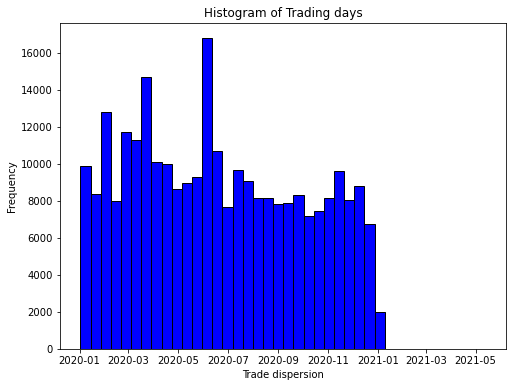

In [85]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(df['trans_dt'], bins = 40, ec='black', fc='blue')
ax.set(xlabel = 'Trade dispersion', ylabel = 'Frequency', title = 'Histogram of Trading days')

# beta.hist()

### 5) Drop bonds that have less than and equal to 100 trading days, how many bonds left?


In [86]:

bonds = df.groupby('bond_sym_id')['trans_dt'].nunique()
bonds = bonds.to_frame()
beta_100 = bonds[bonds<=100]
beta_100.dropna().count()


trans_dt    73
dtype: int64

### 6)

### The data reports the contra-party type. What is the meaning that the contra-party type is “C” versus “D”? Please repeat the following exercise for each subsample with the coutra-party type as “C” and then “D”.

### Calculate spread for each trade as follows. Note that we do not see bid/ask prices at OTC markets, so the calculation of spread is not direct. We follow the calculation in Choi and Huh (2019)

### $$spread = 2Q * \frac{P_{traded} − P_{reference}}{P_{reference}}$$ 
### where Q is +1 for a customer buy and −1 for a customer sell. For each trade, we calculate its reference price as the volume-weighted average price of trades in the same bond-day

----
### Answer

### C stands for Customer and D stands for Dealer.  Spread calculations found below:

In [87]:
#Lets work with a dataframe that's not so obnoxious
df_vwap = df[['ascii_rptd_vol_tx', 'rptd_pr']]
# This is going to give me three column df with my reference price once i set it to a value.  
def vwap(df):
    q = df['ascii_rptd_vol_tx'].values
    p = df['rptd_pr'].values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())


In [89]:
df_vwap = vwap(df_vwap)
df_1 = df[['cusip_id', 'contra_party_type', 'trd_exctn_dt', 'side', 'bond_sym_id', 'company_symbol']]
# lets create the spread dataframe now
df_spread = pd.merge(df_vwap, df_1 , left_index=True, right_index=True)
df_spread['Q'] = df_spread.apply(lambda x: 1 if (x['side'] == 'S') else -1, axis = 1)

df_spread['spread'] = df_spread.apply(lambda x: 2*x['Q']*((x['rptd_pr'] - x['vwap'])/x['vwap']), axis = 1)


In [90]:
df_spread.head()

,ascii_rptd_vol_tx,rptd_pr,vwap,cusip_id,contra_party_type,trd_exctn_dt,side,bond_sym_id,company_symbol,Q,spread
0,7389.16,114.077,114.077000,903436AA1,C,2020-01-07,S,AAL3604479,AAL,1,0.000000
1,7389.16,113.077,113.577000,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.008805
2,14778.33,114.813,114.195000,903436AA1,C,2020-01-07,S,AAL3604479,AAL,1,0.010824
3,14778.33,113.117,113.835667,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.012626
4,17241.39,113.085,113.625480,903436AA1,D,2020-01-08,S,AAL3604479,AAL,1,-0.009513


### 7) Plot the histogram of calculated trade spread. Do you notice that:
###    - lots of spreads are exactly zero,
###    - there are entries with very large spreads? 
    


[Text(0.5, 0, 'Spread Dispersion'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Spread Distribution')]

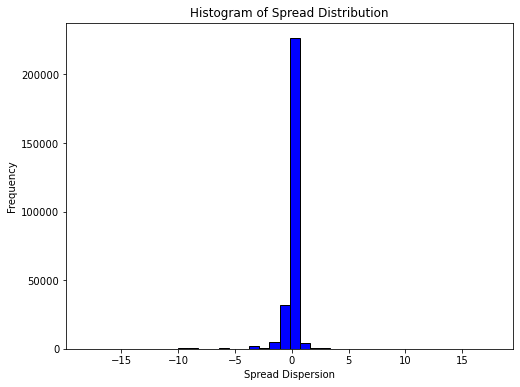

In [91]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(df_spread['spread'], bins = 40, ec='black', fc='blue')
ax.set(xlabel = 'Spread Dispersion', ylabel = 'Frequency', title = 'Histogram of Spread Distribution')

# F

### 8) Drop trades with zero spreads and winsorize spread at 0.5% and 99.5% levels (“winsorize” is to remove outliers, 0.5% from the left tail and 0.5% from the right tail)





In [92]:
spread_df = df_spread.copy()

spread_df = spread_df.loc[spread_df['spread'] != 0]
upper_bound = spread_df['spread'].quantile(.995)
lower_bound = spread_df['spread'].quantile(.005)

filt_high = (spread_df['spread'] > upper_bound)
filt_low = (spread_df['spread'] < lower_bound)
# yes!
len(spread_df['spread']) - (len(spread_df['spread'][filt_high]) + len(spread_df['spread'][filt_low]))

spread_df = spread_df[~(filt_low | filt_high)]



In [93]:
spread_df.head()

,ascii_rptd_vol_tx,rptd_pr,vwap,cusip_id,contra_party_type,trd_exctn_dt,side,bond_sym_id,company_symbol,Q,spread
1,7389.16,113.077,113.577000,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.008805
2,14778.33,114.813,114.195000,903436AA1,C,2020-01-07,S,AAL3604479,AAL,1,0.010824
3,14778.33,113.117,113.835667,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.012626
4,17241.39,113.085,113.625480,903436AA1,D,2020-01-08,S,AAL3604479,AAL,1,-0.009513
5,17241.39,114.781,113.878250,903436AA1,C,2020-01-08,S,AAL3604479,AAL,1,0.015855


### 9) 
   ### Aggregate spread to bond-day level by taking the volume-weighted average of trade-level spreads


In [225]:
spread_df.columns

Index(['ascii_rptd_vol_tx', 'rptd_pr', 'vwap', 'cusip_id', 'contra_party_type',
       'trd_exctn_dt', 'side', 'bond_sym_id', 'company_symbol', 'Q', 'spread'],
      dtype='object')

In [227]:
# aggregating spread to bond-day level
bond_day = spread_df.groupby(['trd_exctn_dt', 'cusip_id']).agg({'spread': np.mean})

# group by day then take weighted average of the spread.
# bond_day['bond_avg_spread'] = bond_day.apply(lambda x:((x['spread']*x['ascii_rptd_vol_tx'])/x['ascii_rptd_vol_tx']), axis = 1)

# # bond_day = bond_day.fillna(0, inplace = True)

bond_day

spread
trd_exctn_dt cusip_id           
2020-01-02   00165AAH1 -0.183611
             00165CAB0 -0.114247
             00165CAD6 -0.143971
             023135AJ5 -0.009057
             023135AM8 -0.006790
...                          ...
2020-12-31   037833EA4 -0.048537
             U0237LAJ4  0.001919
             U0242AAC6  0.120758
             U0242AAD4 -0.160484
             U8810LAA1 -0.110999

[20888 rows x 1 columns]

### 10) Aggregate bond-day level spreads to company-day level by taking the simple average



In [105]:
company_level = spread_df.groupby(['trd_exctn_dt', 'company_symbol']).agg({'spread': np.mean})

company_level.head(10)

spread
trd_exctn_dt company_symbol          
2020-01-02   AAL             0.115340
             AAPL            0.015658
             AMC            -0.150697
             AMZN            0.020127
             TSLA           -0.059407
2020-01-03   AAL             0.001960
             AAPL            0.004295
             AMC            -0.143677
             AMZN            0.031318
             TSLA            0.018350

### 11 – Using bond-day level spreads to calculate the average spread for each stock and present the results. What can we learn from the ranking of the spreads?

----

### Analysis

In [112]:
company_avg_spreads = company_level.reset_index()
company_avg_spreads.groupby('company_symbol')['spread'].mean().sort_values(ascending=False)

company_symbol
AMZN    0.044334
AAPL    0.030212
AAL    -0.033092
TSLA   -0.384666
AMC    -0.708793
Name: spread, dtype: float64

### What we can observe is that there appears to be a more positive customer spread direction for both AMZN and AAPL relative to AMC.

----




### 12)  Plot time-series spread using company-day level data for Apple and Amazon. What patterns do you see, and why is that?

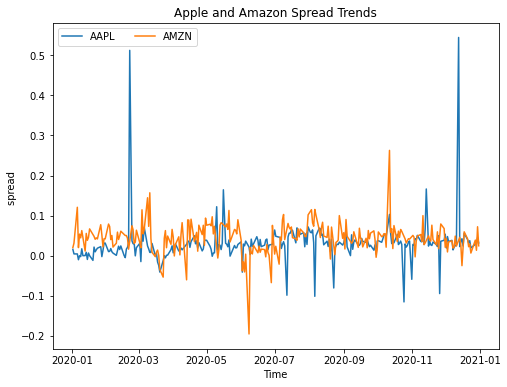

In [117]:
# Lets just throw into dataframes and make a graph
aapl_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AAPL']
aapl_df = aapl_df.set_index('trd_exctn_dt')

amzn_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AMZN']
amzn_df = amzn_df.set_index('trd_exctn_dt')

AMC_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AMC']
AMC_df = AMC_df.set_index('trd_exctn_dt')

plt.figure(figsize=(8,6))
plt.plot(aapl_df['spread'], label='AAPL')
plt.plot(amzn_df['spread'], label = 'AMZN')

plt.xlabel('Time')
plt.ylabel('spread ')
plt.title("Apple and Amazon Spread Trends")
plt.legend(ncol=2)


### 13) Plot time-series spread using company-day level data for AMC. What patterns do you see, and why is that?

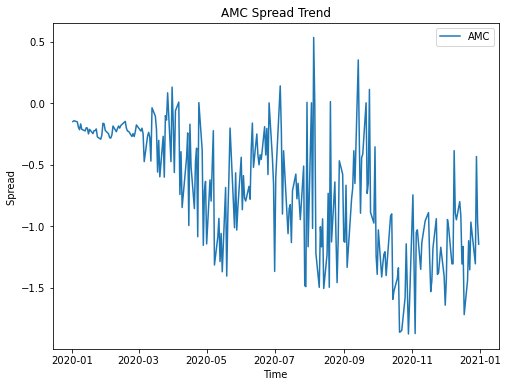

In [118]:
plt.figure(figsize=(8,6))
plt.plot(AMC_df['spread'], label='AMC')
plt.xlabel('Time')
plt.ylabel('Spread ')
plt.title("AMC Spread Trend")
plt.legend(ncol=1)



### There appears to be excess selling pressure and volatility when in comparison to AMZN and AAPL.  This makes sense given the entitie's (AMC) lack of cash flow, high yield nature, and at the time, existing capital structure.

---


### 14) After you finish the analysis for the “C” and “D” coutra-party, what can you conclude about the difference between these two types of trades?

In [122]:
dealers_choice = spread_df[spread_df['contra_party_type'] == 'D']
customer_df = spread_df[spread_df['contra_party_type'] == 'C']

spread_df

,ascii_rptd_vol_tx,rptd_pr,vwap,cusip_id,contra_party_type,trd_exctn_dt,side,bond_sym_id,company_symbol,Q,spread
1,7389.16,113.0770,113.577000,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.008805
2,14778.33,114.8130,114.195000,903436AA1,C,2020-01-07,S,AAL3604479,AAL,1,0.010824
3,14778.33,113.1170,113.835667,903436AA1,D,2020-01-07,S,AAL3604479,AAL,1,-0.012626
4,17241.39,113.0850,113.625480,903436AA1,D,2020-01-08,S,AAL3604479,AAL,1,-0.009513
5,17241.39,114.7810,113.878250,903436AA1,C,2020-01-08,S,AAL3604479,AAL,1,0.015855
...,...,...,...,...,...,...,...,...,...,...,...
275129,500000.00,588.7212,113.419048,88160RAG6,C,2020-09-11,B,TSLA4830349,TSLA,-1,-8.381346
275130,300000.00,598.4531,113.420594,88160RAG6,C,2020-09-11,B,TSLA4830349,TSLA,-1,-8.552812
275136,1000000.00,600.6220,113.443839,88160RAG6,C,2020-09-11,B,TSLA4830349,TSLA,-1,-8.588887
275204,1000000.00,603.2130,113.632919,88160RAG6,C,2020-09-24,B,TSLA4830349,TSLA,-1,-8.616871


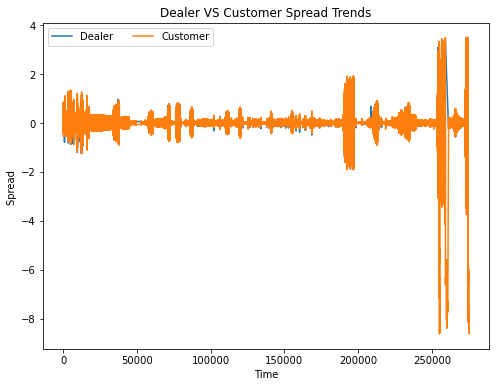

In [123]:
plt.figure(figsize=(8,6))
plt.plot(dealers_choice['spread'], label='Dealer')
plt.plot(customer_df['spread'], label = 'Customer')

plt.xlabel('Time')
plt.ylabel('Spread ')
plt.title("Dealer VS Customer Spread Trends")
plt.legend(ncol=2)


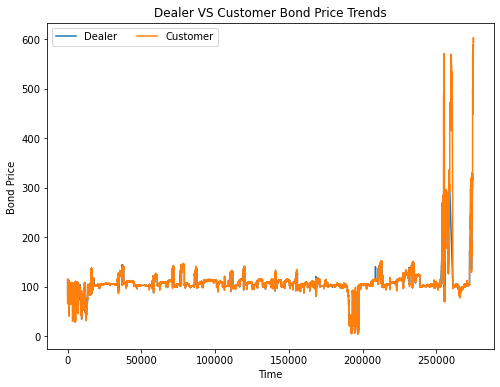

In [166]:
plt.figure(figsize=(8,6))
plt.plot(dealers_choice['rptd_pr'], label='Dealer')
plt.plot(customer_df['rptd_pr'], label = 'Customer')

plt.xlabel('Time')
plt.ylabel('Bond Price ')
plt.title("Dealer VS Customer Bond Price Trends")
plt.legend(ncol=2)

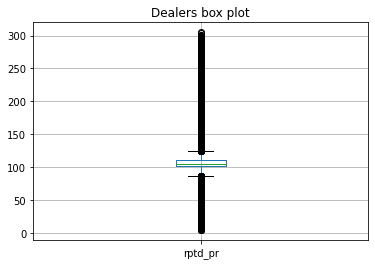

In [129]:



# Draw box plots considering each column of the pandas

# DataFrame as a distribution

dealers_choice['rptd_pr'].plot.box(title="Dealers box plot", grid=True);

plot.show(block=True);

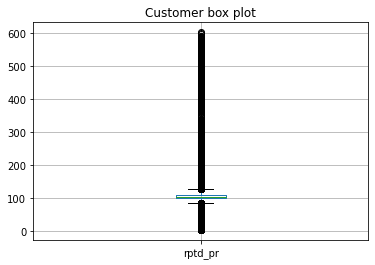

In [130]:

customer_df['rptd_pr'].plot.box(title="Customer box plot", grid=True);

plot.show(block=True);

### Analysis

It appears that the customer price and spread information has a bit more dispersion and more demand than intra dealer trades.

### 15)

### Calculate company-day trading volume by summing trade quantity in one day for one company


In [154]:
#this is an odd question.  
#use aapl.
AAPL_volume = spread_df.groupby(['trd_exctn_dt', 'company_symbol']).agg({'ascii_rptd_vol_tx': np.sum})

In [155]:
AAPL_volume = AAPL_volume.reset_index()
AAPL_volume = AAPL_volume[AAPL_volume['company_symbol'] == 'AAPL']

AAPL_volume.head()

,trd_exctn_dt,company_symbol,ascii_rptd_vol_tx
1,2020-01-02,AAPL,195328000.0
6,2020-01-03,AAPL,121112000.0
11,2020-01-06,AAPL,166802000.0
16,2020-01-07,AAPL,187548000.0
21,2020-01-08,AAPL,247534000.0


### 16)

### Plot histogram of the company-day trading volume. What is the distribution? Winsorize trading volume at 0.5% and 99.5% levels.

---

### Analysis

### The data appears to be a bit left skewed with some outliers to the right.  I will remove outliers directly.


[Text(0.5, 0, 'Volume '),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Volume Distribution (AAPL)')]

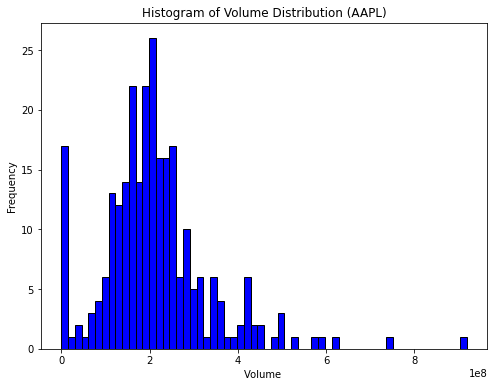

In [157]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(AAPL_volume['ascii_rptd_vol_tx'], bins = 60, ec='black', fc='blue')
ax.set(xlabel = 'Volume ', ylabel = 'Frequency', title = 'Histogram of Volume Distribution (AAPL)')


In [158]:
upper_bound = AAPL_volume['ascii_rptd_vol_tx'].quantile(.995)
lower_bound = AAPL_volume['ascii_rptd_vol_tx'].quantile(.005)

filt_high = (AAPL_volume['ascii_rptd_vol_tx'] > upper_bound)
filt_low = (AAPL_volume['ascii_rptd_vol_tx'] < lower_bound)

AAPL_volume = AAPL_volume[~ (filt_low | filt_high)]

### Run the following regressions and interpret results: No need to output coefficients on fixed effects.

We are only interested in β coefficient. You can refer functions in this website: https://lost-stats.github.io/Model_Estimation/OLS/fixed_effects_in_linear_regression.html


### $$ spread = \beta log(Volume) + \alpha_{data-fixed-effects}$$
### $$ spread = \beta log(Volume) + \alpha_{company-fixed-effects}$$

In [162]:
# fixed effects
from linearmodels import PanelOLS


FE_df = spread_df.copy()
FE_df = FE_df.set_index(['company_symbol','trd_exctn_dt'])
y = FE_df['spread']
FE_df['Constant'] = 1
FE_df['log_vol'] = np.log(FE_df['ascii_rptd_vol_tx'])
#interaction term?
# FE_df['Time_int'] = spread_df['log_vol']*spread_df['trd_exctn_dt']
X_col = ['Constant', 'log_vol']

Time_FE = PanelOLS(y, FE_df[X_col], time_effects=True)
result_time = Time_FE.fit(cov_type = 'clustered', cluster_time = True)  

Company_FE = PanelOLS(y, FE_df[X_col], entity_effects=True)
result_company = Company_FE.fit(cov_type = 'clustered', cluster_entity = True)


print(f"Time Fixed Effects are: {result_time} \n")
print(f"Company Fixed Effects are: {result_company} \n")




Time Fixed Effects are:                           PanelOLS Estimation Summary                           
Dep. Variable:                 spread   R-squared:                        0.0021
Estimator:                   PanelOLS   R-squared (Between):             -0.3986
No. Observations:              272906   R-squared (Within):               0.0034
Date:                Wed, Feb 16 2022   R-squared (Overall):              0.0036
Time:                        10:07:02   Log-likelihood                -2.397e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      585.39
Entities:                           5   P-value                           0.0000
Avg Obs:                    5.458e+04   Distribution:                F(1,272633)
Min Obs:                       7610.0                                           
Max Obs:                     1.72e+05   F-statistic (robust):             3.9260
    

### Analysis:

There appears to be significant fixed effects due to time.  Company sepcific information has a very high standard error for its coefficient.  In addition, Time varying log vol seems to be a bit more informationally sound.

---

### 19: Plot time-series trends for all companies. 
 - Any thoughts on spikes in demand for bonds of Apple and 2 Amazon during the crisis?

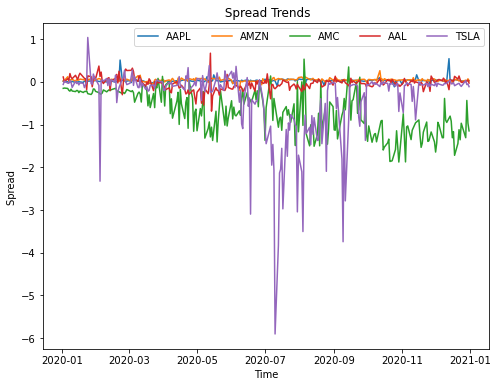

In [165]:
# spread_df.company_symbol.unique()
aapl_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AAPL']
aapl_df = aapl_df.set_index('trd_exctn_dt')

amzn_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AMZN']
amzn_df = amzn_df.set_index('trd_exctn_dt')

AMC_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AMC']
AMC_df = AMC_df.set_index('trd_exctn_dt')

AAL_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'AAL']
AAL_df = AAL_df.set_index('trd_exctn_dt')

TSLA_df = company_avg_spreads[company_avg_spreads['company_symbol'] == 'TSLA']
TSLA_df = TSLA_df.set_index('trd_exctn_dt')

plt.figure(figsize=(8,6))
plt.plot(aapl_df['spread'], label='AAPL')
plt.plot(amzn_df['spread'], label = 'AMZN')
plt.plot(AMC_df['spread'], label = 'AMC')
plt.plot(AAL_df['spread'], label = 'AAL')
plt.plot(TSLA_df['spread'], label = 'TSLA')

plt.xlabel('Time')
plt.ylabel('Spread ')
plt.title(" Spread Trends")
plt.legend(ncol=5)
# That's hilarious


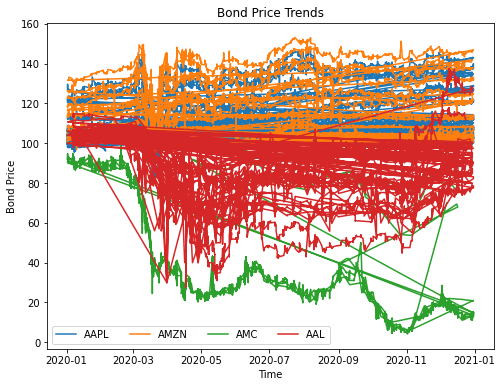

In [168]:
AAPL = spread_df[spread_df['company_symbol'] == 'AAPL']
AAPL = AAPL.set_index('trd_exctn_dt')

AMZN = spread_df[spread_df['company_symbol'] == 'AMZN']
AMZN = AMZN.set_index('trd_exctn_dt')

AMC =   spread_df[spread_df['company_symbol'] == 'AMC']
AMC = AMC.set_index('trd_exctn_dt')

AAL = spread_df[spread_df['company_symbol'] == 'AAL']
AAL = AAL.set_index('trd_exctn_dt')

TSLA =  spread_df[spread_df['company_symbol'] == 'TSLA']
TSLA = TSLA.set_index('trd_exctn_dt')


plt.figure(figsize=(8,6))

plt.plot(AAPL['rptd_pr'], label='AAPL')
plt.plot(AMZN['rptd_pr'], label = 'AMZN')
plt.plot(AMC['rptd_pr'], label = 'AMC')
plt.plot(AAL['rptd_pr'], label = 'AAL')
# plt.plot(TSLA['rptd_pr'], label = 'TSLA')

plt.xlabel('Time')
plt.ylabel('Bond Price')
plt.title("Bond Price Trends")
plt.legend(ncol=4)

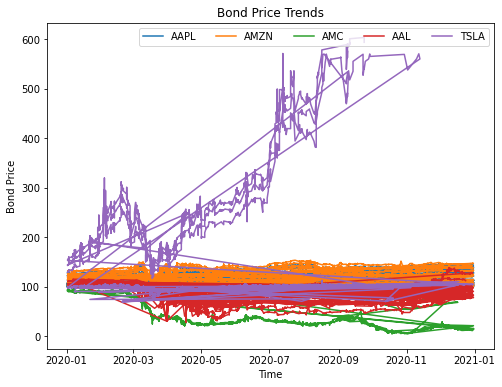

In [170]:
plt.figure(figsize=(8,6))

plt.plot(AAPL['rptd_pr'], label='AAPL')
plt.plot(AMZN['rptd_pr'], label = 'AMZN')
plt.plot(AMC['rptd_pr'], label = 'AMC')
plt.plot(AAL['rptd_pr'], label = 'AAL')
plt.plot(TSLA['rptd_pr'], label = 'TSLA')

plt.xlabel('Time')
plt.ylabel('Bond Price')
plt.title("Bond Price Trends")
plt.legend(ncol=5)



### Analysis

There appears to be significant dispersion with TSLA.  Prices for bonds on TSLA do not appear trustworty and spreads seem not to align. 

Demand for AMZN and AAPL bonds suggest flight to quality during a volatile market. 

# 2 Bitcoin
This exercise is about Bitcoin. The data records all trades at Coinbase in March 2020. Unluckily, we only
see market price and quantity traded. But the data gives the indicator of “BUY” or “SELL” on the taker side.
This indicator is not available for most of equity trades dataset.

---------

In [273]:
import os
import numpy as np
import pandas as pd
import glob
import pickle


path = r"C:\Users\user\Documents"
#Glob data
# if os.path.exists(path + '/' + 'BTC_aggregate_trades') == False:
#     filesindir = glob.glob(path + '/' + '*.csv')
#     BTC = pd.read_csv(filesindir[0], sep=';')
#     for file in filesindir[1:]:
#         BTC.append(pd.read_csv(file, sep=';'))
    
#     BTC.to_pickle(path + '/' + 'BTC_aggregate_trades')
    

if os.path.exists(path + '/' + 'BTC_large'):
    BTC = pd.read_pickle(path + '/' + 'BTC_large')
else:
    print('REGLOB')
BTC['time_exchange'] = pd.to_datetime(BTC['time_exchange'])


BTC.shape

(3459934, 11)

### 1)  Find Kyle'S Lambda for March.  

Kyle's Lambda

A measure of market impact cost from Kyle (1985), which can be interpreted as the cost of demanding a certain amount of liquidity over a given time period.

It is also used as a measure of market liquidity and can be estimated by the volume required to move the price of a security by one dollar. Sometimes referred to as Kyles lambda, this measure is an inverse proxy of liquidity, with higher values of lambda implying lower liquidity and market depth. The authors estimate this measure on a daily basis by using all transactions during normal trading hours on each day.

## $$ \mathbb{E}[v|q] = \mu + \lambda q == > \lambda = \frac{p-\mu}{q}$$
## $$ \lambda = \frac{Cov_{v,q}}{Var_{q}}$$

### In our context, for security "i" in March during a given day, the following regression is estimated:

## $$ R_{i,t} = \alpha_{i} + \lambda_{i}Sgn(t)ln(v_{i,t} * p_{i,t}) + \epsilon_{i,t}$$

----

### 1)  Calculate Kyle’s lambda (market impact) for all the data in March?

In [275]:
import frds
# from frds.measures import kyle_lambda
from sklearn.linear_model import LinearRegression

In [276]:
BTC['volumne'] = BTC['base_amount']
BTC[:3]

,time_exchange,time_coinapi,guid,price,base_amount,taker_side,id_coinapi,id_exch_guid,id_exch_int_inc,order_id_maker,order_id_taker,volumne
0,2020-03-01 00:00:00.044614,2020-03-01T00:00:00.1414456,679ee89b-5519-43f1-923b-daded92057f3,8523.33,0.40000,BUY,NaN,NaN,NaN,NaN,NaN,0.40000
1,2020-03-01 00:00:00.044614,2020-03-01T00:00:00.1423443,d8e7d6bd-7393-4ec9-8e26-7908029c9d21,8523.33,0.06015,BUY,NaN,NaN,NaN,NaN,NaN,0.06015
2,2020-03-01 00:00:00.304961,2020-03-01T00:00:00.3886382,d0226b21-0475-44c2-9eaa-549c58af18b7,8523.33,0.00181,BUY,NaN,NaN,NaN,NaN,NaN,0.00181


In [277]:
BTC['directional_price'] = BTC.apply(lambda x: 1 if (x['taker_side'] == 'BUY') else -1 , axis = 1)
BTC['abs_price_rtr'] = abs(BTC['price'].pct_change(1).dropna())
BTC['Trade_dollar_size'] = BTC.apply(lambda x: x['base_amount']*x['price'], axis = 1 )

In [278]:
BTC = BTC.set_index(BTC['time_exchange'])
BTC = BTC[1:]
BTC.head()

,time_exchange,time_coinapi,guid,price,base_amount,taker_side,id_coinapi,id_exch_guid,id_exch_int_inc,order_id_maker,order_id_taker,volumne,directional_price,abs_price_rtr,Trade_dollar_size
time_exchange,,,,,,,,,,,,,,,
2020-03-01 00:00:00.044614,2020-03-01 00:00:00.044614,2020-03-01T00:00:00.1423443,d8e7d6bd-7393-4ec9-8e26-7908029c9d21,8523.33,0.060150,BUY,NaN,NaN,NaN,NaN,NaN,0.060150,1,0.000000,512.678044
2020-03-01 00:00:00.304961,2020-03-01 00:00:00.304961,2020-03-01T00:00:00.3886382,d0226b21-0475-44c2-9eaa-549c58af18b7,8523.33,0.001810,BUY,NaN,NaN,NaN,NaN,NaN,0.001810,1,0.000000,15.429699
2020-03-01 00:00:00.603222,2020-03-01 00:00:00.603222,2020-03-01T00:00:00.6882787,1ca08d8d-a93f-4f99-9797-68b2dc1f5c23,8523.32,0.017000,SELL,NaN,NaN,NaN,NaN,NaN,0.017000,-1,0.000001,144.896440
2020-03-01 00:00:00.603222,2020-03-01 00:00:00.603222,2020-03-01T00:00:00.6889379,0e44b485-17e1-48d3-b0ae-2a46c3c43b38,8523.32,0.008014,SELL,NaN,NaN,NaN,NaN,NaN,0.008014,-1,0.000000,68.304097
2020-03-01 00:00:01.065901,2020-03-01 00:00:01.065901,2020-03-01T00:00:01.1510480,9642ae73-f565-47e0-8cb9-a44f72f327f8,8523.33,0.001460,BUY,NaN,NaN,NaN,NaN,NaN,0.001460,1,0.000001,12.445255


In [279]:
reg = LinearRegression().fit(BTC["Trade_dollar_size"].values.reshape(-1, 1), BTC["abs_price_rtr"].values)

In [323]:
kyle_lambda = reg.coef_
print(f"Kyle's lambda for ALL of MARCH is : {kyle_lambda}")

Kyle's lambda for ALL of MARCH is : [-3.48445915e-09]


### 2)  Calculate Kyle’s lambda (market impact), volume, signed volume, volume-weighted price by hour

In [281]:
BTC.columns.sort_values()

Index(['Trade_dollar_size', 'abs_price_rtr', 'base_amount',
       'directional_price', 'guid', 'id_coinapi', 'id_exch_guid',
       'id_exch_int_inc', 'order_id_maker', 'order_id_taker', 'price',
       'taker_side', 'time_coinapi', 'time_exchange', 'volumne'],
      dtype='object')

In [282]:
BTC = BTC.reset_index(drop = True)
hr_btc =BTC.resample('1H', on = 'time_exchange').agg({'price' : np.mean,'base_amount':np.sum, 'directional_price':np.sum, 
                                                         "Trade_dollar_size" : np.sum, 'abs_price_rtr': np.mean})
hr_btc['vwap_per_hour'] = hr_btc.apply(lambda x: x['Trade_dollar_size']/x['base_amount'], axis = 1)
hr_btc[:5]

,price,base_amount,directional_price,Trade_dollar_size,abs_price_rtr,vwap_per_hour
time_exchange,,,,,,
2020-03-01 00:00:00,8571.774353,514.219429,1088,4.405692e+06,0.000052,8567.727402
2020-03-01 01:00:00,8566.824289,391.800589,1082,3.354198e+06,0.000046,8560.983080
2020-03-01 02:00:00,8637.605797,248.169058,1017,2.143611e+06,0.000056,8637.702911
2020-03-01 03:00:00,8635.287055,266.848771,1119,2.302869e+06,0.000043,8629.865826
2020-03-01 04:00:00,8585.868744,305.307608,469,2.619585e+06,0.000034,8580.148682


In [283]:
## Calculate Kyle's lambda hourly
reg_hr = LinearRegression().fit(hr_btc["Trade_dollar_size"].values.reshape(-1, 1), hr_btc["abs_price_rtr"].values)

kyle_lambda_hr = reg_hr.coef_
print(f"Kyle's hourly lambda is : {kyle_lambda_hr}")

Kyle's hourly lambda is : [9.44200847e-12]


### 3  Plot all constructed variables

 - What patterns do you see? Make some comments
 - Is there momentum in the series? 

In [284]:
hr_btc.columns.sort_values

<bound method Index.sort_values of Index(['price', 'base_amount', 'directional_price', 'Trade_dollar_size',
       'abs_price_rtr', 'vwap_per_hour'],
      dtype='object')>

In [285]:
hr_btc['price'][1:].shape
hr_btc['directional_price'].pct_change(1).dropna().shape

(719,)

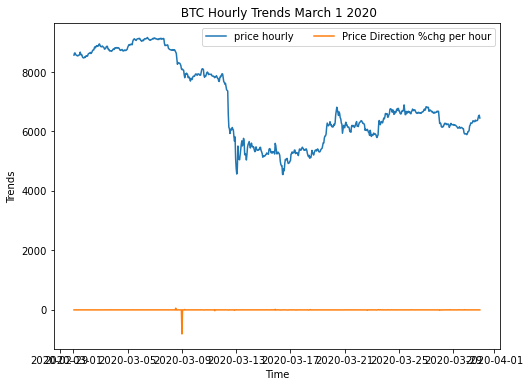

In [287]:
plt.figure(figsize=(8,6))

# hr_btc = hr_btc.set_index(hr_btc[''])
plt.plot(hr_btc['price'][1:], label = 'price hourly')
plt.plot(hr_btc['directional_price'].pct_change(1).dropna(), label='Price Direction %chg per hour')
# plt.plot(hr_btc['Trade_dollar_size'], label = 'Trade Size (USD) per hour')

plt.xlabel('Time')
plt.ylabel('Trends')
plt.title(" BTC Hourly Trends March 1 2020")
plt.legend(ncol=2)


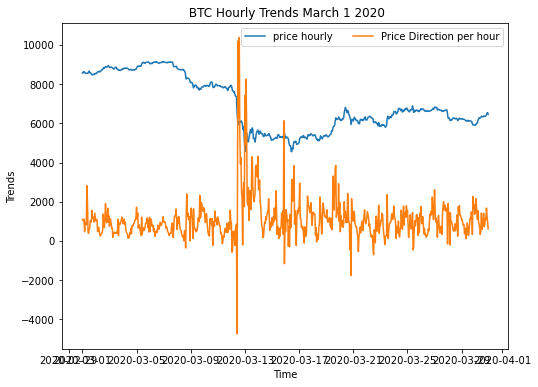

In [292]:
plt.figure(figsize=(8,6))

plt.plot(hr_btc['price'], label = 'price hourly')
plt.plot(hr_btc['directional_price'], label='Price Direction per hour')
# plt.plot(hr_btc['Trade_dollar_size'], label = 'Trade Size (USD) per hour')

plt.xlabel('Time')
plt.ylabel('Trends')
plt.title(" BTC Hourly Trends March 1 2020")
plt.legend(ncol=2)

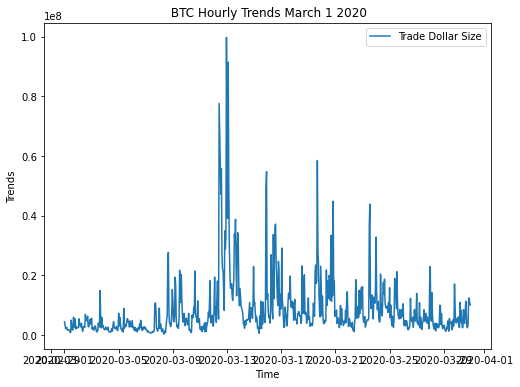

In [293]:
plt.figure(figsize=(8,6))

plt.plot(hr_btc['Trade_dollar_size'], label = 'Trade Dollar Size')
# plt.plot(hr_btc['vwap_per_hour'], label = 'Hourly Vwap')

plt.xlabel('Time')
plt.ylabel('Trends')
plt.title(" BTC Hourly Trends March 1 2020")
plt.legend(ncol=1)

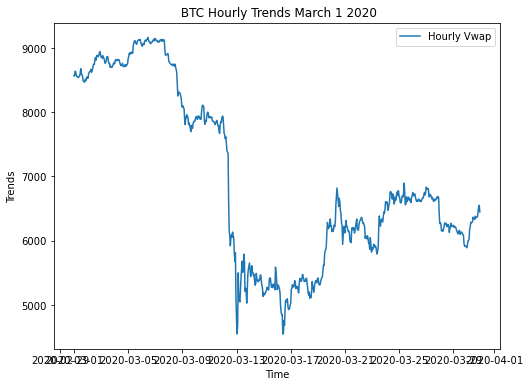

In [294]:
plt.figure(figsize=(8,6))

plt.plot(hr_btc['vwap_per_hour'], label = 'Hourly Vwap')

plt.xlabel('Time')
plt.ylabel('Trends')
plt.title(" BTC Hourly Trends March 1 2020")
plt.legend(ncol=1)

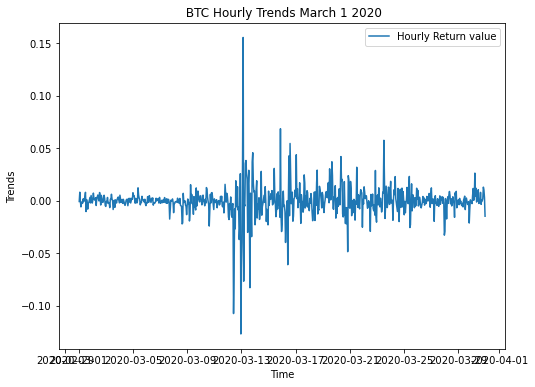

In [297]:
plt.figure(figsize=(8,6))

plt.plot(hr_btc['price'].pct_change(1).dropna(), label = 'Hourly Return value')

plt.xlabel('Time')
plt.ylabel('Trends')
plt.title(" BTC Hourly Trends March 1 2020")
plt.legend(ncol=1)

[Text(0.5, 0, 'Kyel_Lambda_simulated'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Histogram of Kyles_hourly_lambda')]

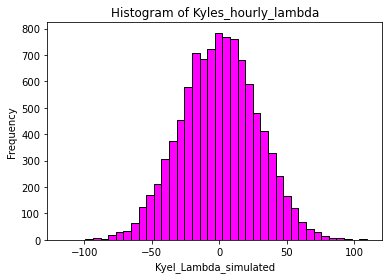

In [298]:
# =============================================================================
# let's simulate sampling distribution of Kyels Lambda
# =============================================================================
def simreg(beta0, beta1, sigma, x):
    y = beta0 + beta1 * x + np.random.normal(loc = 0, scale = sigma, size = len(x))
    return(y)

x= hr_btc['abs_price_rtr']
beta0= 0.0 
beta1= kyle_lambda_hr
sigma=0.1
nsample=10000
k_sim = list()
for i in range(nsample):
    y = simreg(beta0, beta1, sigma, x)
    k = sm.OLS(y, sm.add_constant(x), missing = 'drop').fit().params[1]
    k_sim.append(k)

#plot histogram
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(k_sim, bins = 40, ec = 'black', fc = 'magenta')
ax.set(xlabel = 'Kyel_Lambda_simulated', ylabel = 'Frequency', title = 'Histogram of Kyles_hourly_lambda') 


###  Analysis:

Though there does not appear to be momemtum in daily data.  There does appear to be momentum in daily price observations during the time period in MARCH.  Given I cannot important CSV files from coinbase with this data, timeseries analysis from ALPHA sense shows momentum in the period.

Kyles lambda does also appear to have information regarding the market depth.

### Can you figure out good predictor variables for returns?

In [321]:
# LETS DO IT!

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import RegressionResults
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [304]:
hour_returns = hr_btc['price'].pct_change(1).dropna()

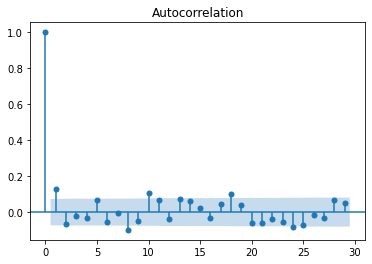

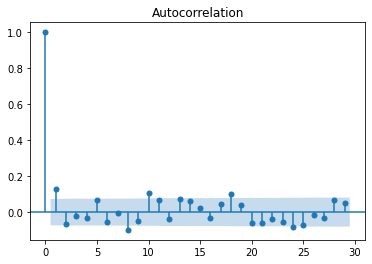

In [305]:
plot_acf(hour_returns)

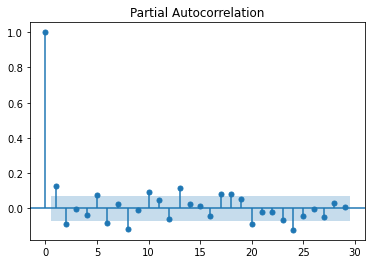

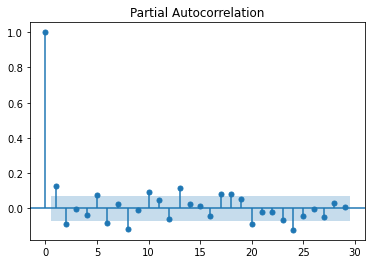

In [307]:
plot_pacf(hour_returns)

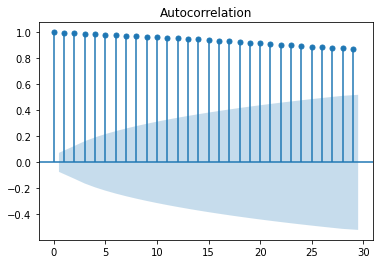

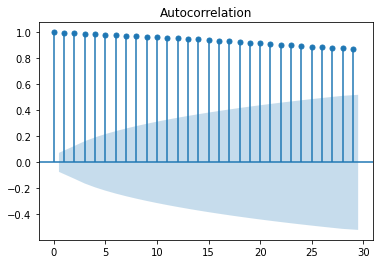

In [302]:
plot_acf(hr_btc['vwap_per_hour'])

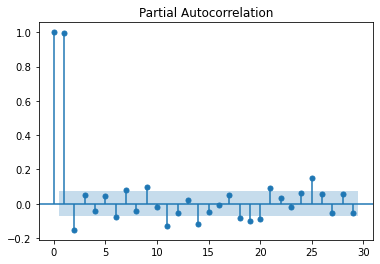

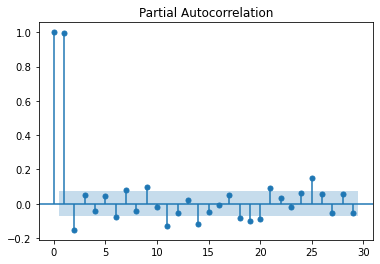

In [306]:
# AR(1 EVIDENCE expectation of previous hour indicative of next hour price.  
plot_pacf(hr_btc['vwap_per_hour'])

In [313]:
hour_time = hr_btc.reset_index()
hour_time['time_exchange'].iloc[1:].shape


(719,)

In [ ]:
x = hour_time['time_exchange'].iloc[1:].shape
y = sm.tsa.stattools.acf(hour_returns, nlags =60).cumsum()

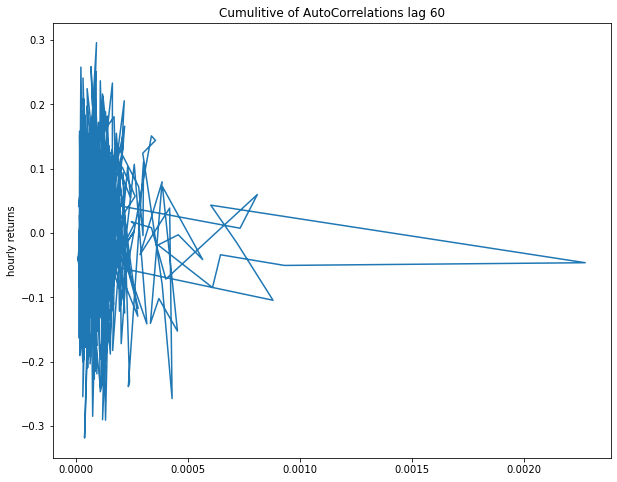

In [314]:
plt.figure(figsize=(10,8))
plt.plot(x,y)
plt.ylabel('hourly returns')
plt.title("Cumulitive of AutoCorrelations lag 60")
plt.show()

In [318]:
#  Does this produce stationarity?
return_phi1 = sm.tsa.acf(hour_returns, nlags=1, fft=False)[1]
return_half = np.log(0.5)/np.log(return_phi1)
print(f"The return phi 1 is: {return_half}. This is stationary.  Given output of PACF and ACF apply ARMA (1,1)")

The return phi 1 is: 0.3386734643523579. This is stationary.  Given output of PACF and ACF apply ARMA (1,1)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([0.09003923]), array([0.76412729]))

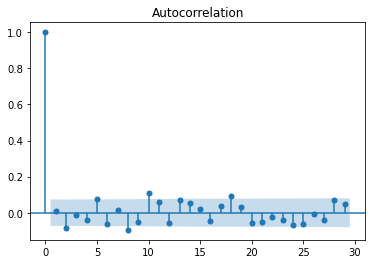

In [319]:
# LETS Just check HOURLY returns AR(1) RESIDUAL component via box jung test:
AR_hourly_rtr = sm.OLS(hour_returns, sm.add_constant(hour_returns.shift(1)), missing = 'drop').fit().resid
sm.graphics.tsa.plot_acf(AR_hourly_rtr)
sm.stats.acorr_ljungbox(AR_hourly_rtr, lags = [1])
# YEAAAA no correlation in residuals as confirmed with box jung.  proceed!

In [322]:
ARMA_model = ARMA(hour_returns, order = (1,1))
model_fit = ARMA_model.fit()
print(model_fit.summary())

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  719
Model:                     ARMA(1, 1)   Log Likelihood                1995.952
Method:                       css-mle   S.D. of innovations              0.015
Date:                Wed, 16 Feb 2022   AIC                          -3983.903
Time:                        21:43:12   BIC                          -3965.592
Sample:                    03-01-2020   HQIC                         -3976.833
                         - 03-30-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.001     -0.462      0.644      -0.001       0.001
ar.L1.price    -0.7673      0.057    -13.569      0.000      -0.878      -0.656
ma.L1.price     0.8934      0.039     22.767    


### Analysis

I would like to play around with this a bit more.  I'm concerned with AIC a bit but the coefficients confidence interval is "ok".

I have Stationarity concerns. I would like to further investigate VAR models with other cross sectional data.   